In [1]:
# %env WANDB_PROJECT=nlu_sentiment_analysis
# !wandb login 2cad8a8279143c69ce071f54bf37c1f5a5f4e5ff
# import wandb

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn
from torch.utils.data import DataLoader

from datasets import Dataset
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

import plotly.graph_objects as go

PATH = "./data/"
device = "cuda:0"

##### text preprocessing

In [3]:
"""Tokenization classes for Italian AlBERTo models."""
import collections
import os

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens

    unpack_hashtags=True,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

a = AlBERTo_Preprocessing(do_lower_case=True)
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)
print(b)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
<hashtag> il governo </hashtag> presenta le linee guida sulla scuola <hashtag> la buona scuola </hashtag> <url>


##### pretrained tokenizer and AlBERTo

In [4]:
from transformers import AutoTokenizer, AutoModel

def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

a = AlBERTo_Preprocessing(do_lower_case=True)
s: str = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)

tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = 128 #model.config.max_position_embeddings
tokens = tok.tokenize(b)
print(tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


##### models

In [5]:
class MyNetMC(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMC, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
class MyNetMCTuned(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer without Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetMCTuned, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)
        self.linear = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        logits = self.linear(outputs[1])
        loss = self.loss_fct(logits, labels)
        return logits , loss

#####  utility functions

In [52]:
def validation_epoch(model, epoch, val_loader, kind, logging):
    model.eval()
    targets , outputs , logitss = [] , [] , []
    cumulative_loss = 0.
    with torch.no_grad():
        for i , data in enumerate(val_loader, 0):
            batch = {k: v.to(device) for k, v in data.items()}
            logits , loss = model(**batch)
            if kind != "test": cumulative_loss += loss.detach()
            if (i+1) % 25 == 0 and logging:
                print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
            
            targets.extend(batch["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())
    if logging: wandb.log({kind: {'loss': cumulative_loss.item() / len(outputs)}})
    return outputs, targets, logitss


def eval_feelit_model(dataset, keep_neutrals, dataset_name, plot_confidence=False):
    tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
    tok_feelit.model_max_length = 128

    model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment").to(device)
    model.eval()

    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    else:
        testing = Dataset.from_pandas(dataset)\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 1)\
                .filter(lambda example: example['labels'] != 3)\
                .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_loader = DataLoader(testing, batch_size=64)

    trues , preds , logitss = [] , [] , []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
            logits = model(**batch)[0]
            trues.extend(data["labels"].detach().numpy())
            preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())

    proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
    assert len(preds) == len(proba) and np.all(np.array((proba[:,1] + proba[:,0]) >= 0.99))
    for i in range(len(proba)):
        if keep_neutrals:
            if preds[i] == 1: 
                preds[i] = 2
            if max(proba[i,0] , proba[i, 1]) <= 0.55: #set to neutral  if the prediction's confidence is too low
                preds[i] = 1
        else:
            if trues[i] == 2: #the net produces just [0,1] for positive/negative, so adjust label
                trues[i] = 1

    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))
    cm = confusion_matrix(trues, preds, normalize='all')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets).plot()
    tmp = "no neutral" if not keep_neutrals else ""
    plt.title(f"{dataset_name} {tmp} - Feel-it pretrained")

    if plot_confidence:
        trues = np.array(trues)
        preds = np.array(preds)
        #plot_confidence_distribution(trues, preds, proba, name="Feel-it model", dataset="SENTIPOLC no neutral", plot_neutral=False, adjust_positive=True)
        
        
def train_epoch(model, train_loader, optimizer, scheduler, epoch, logging):
    model.train()
    targets , outputs = [] , []
    cumulative_loss = 0.
    for i , data in enumerate(train_loader, 0): 
        targets.extend(data["labels"].numpy())
        
        batch = {k: v.to(device) for k, v in data.items()}
        logits , loss = model(**batch)

        cumulative_loss += loss.detach()
        if (i+1) % 25 == 0 and logging:
            print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
    return outputs, targets

def fine_tune(train_loader, model, logging, model_type, dataset_val=None):
    if model_type == "opt":
        hyper = {'learning_rate': 3.000003529363845e-06, 'warmup_steps': 0.6, 'weight_decay': 0.000260393798851559}
    elif model_type == "MC":
        hyper = {'learning_rate': 2e-5, 'warmup_steps': 0.1, 'weight_decay': 0.1}
        
    optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyper["learning_rate"],
                              weight_decay=hyper["weight_decay"], 
                              eps=1e-6)
    num_epochs = 3
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    num_warmup_steps =  int(num_train_steps * hyper["warmup_steps"])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
    
    for epoch in range(num_epochs):
        outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
        #outputs, targets = validation_epoch(model, epoch, val_loader, "val", logging=False)
        #f1_val = f1_score(targets, outputs, average='macro')
        #if f1_val > best_value:
        #    best_value = f1_val
        #    torch.save(model.state_dict(), "data/models/alberto_multiclass_tuned.pt")    
        #if early_stopping.on_epoch_end(epoch, f1_val):
        #    print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        #    break

        if logging: 
            f1_train = f1_score(targets, outputs, average='macro')
            print(f"Train F1 = {f1_train}")
    return model
        

def eval_alberto(model, model_name, model_params, dataset, dataset_name, keep_neutrals, plot_confidence, fine_tuning=False, dataset_train=None, logging=False, model_type=None):
    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(tokenize_function, batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    else:
        testing = Dataset.from_pandas(dataset)\
                    .filter(lambda example: example['labels'] != 1)\
                    .filter(lambda example: example['labels'] != 3)\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
    test_loader = DataLoader(testing, batch_size=64)

    model = model(3).to(device)
    model.load_state_dict(torch.load(PATH + model_params))
    
    if fine_tuning:
        if keep_neutrals:
            training = Dataset.from_pandas(dataset_train)\
                            .filter(lambda example: example['labels'] != 3)\
                            .map(tokenize_function, batched=True)\
                            .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
        else:
            training = Dataset.from_pandas(dataset_train)\
                        .filter(lambda example: example['labels'] != 1)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(tokenize_function, batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
        train_loader = DataLoader(training, batch_size=64)
        model = fine_tune(train_loader, model, logging, model_type)

    preds , trues , logitss = validation_epoch(model, None, test_loader, "test", logging=False)
    for i in range(len(preds)):
        if not keep_neutrals:
            if preds[i] == 2: 
                preds[i] = 1
            if trues[i] == 2: 
                trues[i] = 1
                
    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(trues, preds, normalize='all'), display_labels=targets).plot()
    tmp = "no neutrals" if not keep_neutrals else ""
    plt.title(f"{dataset_name} - {model_name} {tmp}")
    
    if plot_confidence:
        proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
        trues = np.array(trues)
        preds = np.array(preds)

        plot_confidence_distribution(trues, preds, proba, name=model_name, dataset=dataset_name, plot_neutral=True)

In [2]:
def plot_confidence_distribution(trues, preds, proba, name, dataset, plot_neutral, adjust_positive=False):
    false_negatives = np.logical_and(trues != 0, preds == 0)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_negatives, np.argmax(proba[false_negatives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        title=f"{name}'s confidence distribution for {dataset} - false negatives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()

    if plot_neutral:
        false_neutrals = np.logical_and(trues != 1, preds == 1)
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=proba[false_neutrals, np.argmax(proba[false_neutrals,:], axis=1)], 
                                   xbins=dict(
                                    start=0.,
                                    end=1.0,
                                    size=0.1
                                    ), 
                                   histnorm='probability'))
        fig.update_layout(
            title=f"{name}'s confidence distribution for {dataset} - false neutrals",
            xaxis_title="confidence",
            yaxis_title="normalized count",
        )
        fig.update_xaxes(range=[0., 1.])
        fig.show()

    false_positives = np.logical_and(trues != 2, preds == 2) if not adjust_positive else np.logical_and(trues != 1, preds == 1)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=proba[false_positives, np.argmax(proba[false_positives,:], axis=1)], 
                               xbins=dict(
                                start=0.,
                                end=1.0,
                                size=0.1
                                ), 
                               histnorm='probability'))
    fig.update_layout(
        title=f"{name}'s confidence distribution for {dataset} - false positives",
        xaxis_title="confidence",
        yaxis_title="normalized count",
    )
    fig.update_xaxes(range=[0., 1.])
    fig.show()

# SENTIPOLC16

In [7]:
train_sentipolc = pd.read_csv(PATH + "Sentipolc16/training_set_sentipolc16.csv")

In [8]:
file1 = open(PATH + "Sentipolc16/test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test_sentipolc = []
for line in Lines:
  arr = line.split("\",")
  if len(arr) != 9:
    arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
    del arr[9:]
  for i in range(8):
    arr[i] = int(arr[i].strip("\""))
  test_sentipolc.append(arr)

test_sentipolc = pd.DataFrame(test_sentipolc, columns=train_sentipolc.columns)
test_sentipolc.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,"""Tra 5 minuti presentazione piano scuola del g..."
1,507075789456961536,1,1,0,0,1,0,2,"""\""@matteorenzi: Alle 10 appuntamento su http:..."
2,507077511902425088,1,0,1,0,0,1,2,"""#labuonascuola gli #evangelisti #digitali non..."
3,507079183315787777,0,0,0,0,0,0,2,"""Riforma scuola Tutto il discorso di Renzi su..."
4,507080190225563648,1,0,0,0,0,0,2,""".@matteorenzi @MiurSocial #labuonascuola bast..."


In [18]:
def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed    -> 3
    """
    if row["opos"] == 0 and row["oneg"] == 0:
        return 1
    elif row["oneg"] == 0 and row["opos"] == 1:
        return 2
    elif row["oneg"] == 1 and row["opos"] == 0:
        return 0
    else:
        return 3


dataset_sentipolc = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})

### AlBERTo pretrained - SENTIPOLC16



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964



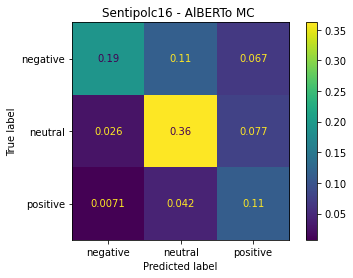

In [19]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_sentipolc, "Sentipolc16", keep_neutrals=True, plot_confidence=True)

### AlBERTo opt - SENTIPOLC16



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.85      0.55      0.67       734
     neutral       0.70      0.85      0.76       914
    positive       0.53      0.63      0.58       316

    accuracy                           0.70      1964
   macro avg       0.69      0.68      0.67      1964
weighted avg       0.73      0.70      0.70      1964



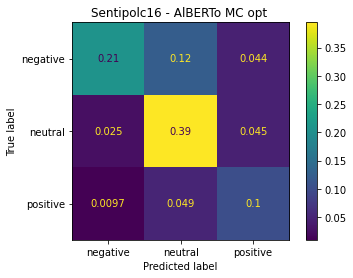

In [13]:
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_sentipolc, "Sentipolc16", keep_neutrals=True, plot_confidence=True)

### Feel-it model - SENTIPOLC16
Note that it was trained just for positive/negative class, so the neutral class is taken for examples with low confidence in the prediction.


              precision    recall  f1-score   support

    negative       0.60      0.89      0.72       734
     neutral       0.33      0.00      0.00       914
    positive       0.29      0.80      0.42       316

    accuracy                           0.46      1964
   macro avg       0.41      0.56      0.38      1964
weighted avg       0.43      0.46      0.34      1964




              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       734
    positive       0.76      0.80      0.78       316

    accuracy                           0.86      1050
   macro avg       0.83      0.85      0.84      1050
weighted avg       0.87      0.86      0.86      1050



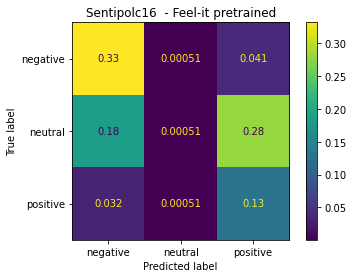

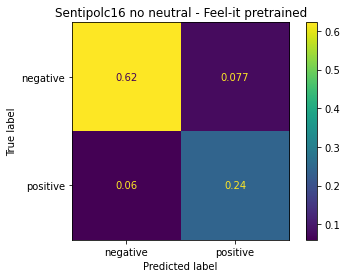

In [20]:
dataset = pd.DataFrame({"text": test_sentipolc.text.apply(a.preprocess), "idx": test_sentipolc.index, "labels": test_sentipolc[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
eval_feelit_model(dataset, keep_neutrals=True, dataset_name="Sentipolc16", plot_confidence=False)
eval_feelit_model(dataset, keep_neutrals=False, dataset_name="Sentipolc16", plot_confidence=False)

# FEEL-IT dataset

In [22]:
train_feel_it = pd.read_csv(PATH + "Feel-it/feelit.tsv", sep='\t', header=0, names=["text", "label"])
print("\nAverage tweet lenght: ", np.mean(train_feel_it["text"].apply(len)))
train_feel_it.head()


Average tweet lenght:  141.8939617083947


,text,label
0,"@USER Adoro questa canzone, è una delle mie pr...",joy
1,#MilanNovara È arrivato il 3 gol del MILAN ❤🖤...,joy
2,stream icarus falls 🖤 zayn ha un talento ed è ...,sadness
3,Persona di indiscutibile cultura #Daverio avev...,sadness
4,Oggi la direttrice @USER ha spiegato che #COVI...,fear


In [24]:
def emotion2sentiment(row):
    """
        Return a single scalar integer label associated to the emotion of the tweet.

        joy -> 2
        anger sadness fear  -> 0
    """
    if row["label"] == "joy":
        return 2
    elif row["label"] == "sadness" or row["label"] == "fear" or row["label"] == "anger":
        return 0
    else:
        raise ValueError('Value not recognized')

#train set
dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})

### AlBERTo pretrained - FEEL-IT
Recall that FEEL_IT does not have neutral tweets, but AlBERTo was trained with such class



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.95      0.83      0.89      1309
     neutral       0.00      0.00      0.00         0
    positive       0.83      0.82      0.83       728

    accuracy                           0.83      2037
   macro avg       0.59      0.55      0.57      2037
weighted avg       0.91      0.83      0.87      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



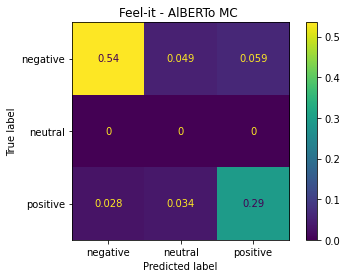

In [25]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_feel_it, "Feel-it", keep_neutrals=True, plot_confidence=False)

### AlBERTo opt - Feel-IT



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.94      0.84      0.88      1309
     neutral       0.00      0.00      0.00         0
    positive       0.82      0.84      0.83       728

    accuracy                           0.84      2037
   macro avg       0.59      0.56      0.57      2037
weighted avg       0.90      0.84      0.86      2037



/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


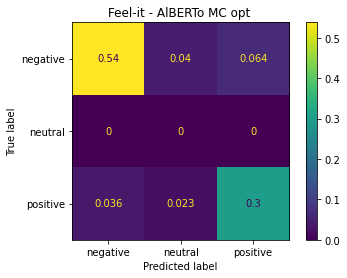

In [17]:
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_feel_it, "Feel-it", keep_neutrals=True, plot_confidence=False)

### FEEL_IT model - FEEL_IT dataset


              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      1309
    positive       0.97      0.99      0.98       728

    accuracy                           0.99      2037
   macro avg       0.98      0.99      0.99      2037
weighted avg       0.99      0.99      0.99      2037



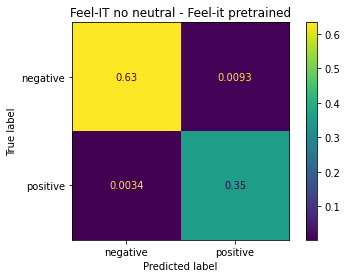

In [27]:
dataset_feel_it = pd.DataFrame({"text": train_feel_it.text.apply(a.preprocess), "idx": train_feel_it.index, "labels": train_feel_it[["label"]].apply(emotion2sentiment, axis=1)})
eval_feelit_model(dataset_feel_it, keep_neutrals=False, dataset_name="Feel-IT", plot_confidence=False)

# Amazon reviews

In [17]:
##
# To split the dataset, one split, read the directly the 2 files
##

# amazon = pd.read_json(PATH + "Amazon-reviews/Amazon_reviews_computer_cloths_food_shoaps.json")
# X_train, X_test = train_test_split(amazon, test_size=0.3, random_state=42, stratify=amazon["rating"])
# X_train.to_json(PATH + "Amazon-reviews/amazon_train.json")
# X_test.to_json(PATH + "Amazon-reviews/amazon_test.json")

In [55]:
amazon_train = pd.read_json(PATH + "Amazon-reviews/amazon_train.json")
amazon_test = pd.read_json(PATH + "Amazon-reviews/amazon_test.json")

amazon_train["text"] = amazon_train["title"] + ": " +  amazon_train["text"]
amazon_test["text"] = amazon_test["title"] + ": " +  amazon_test["text"]

print("Train: ", len(amazon_train) , np.unique(amazon_train.rating, return_counts=True)[1]/len(amazon_train))
print("Test:", len(amazon_test) , np.unique(amazon_test.rating, return_counts=True)[1]/len(amazon_test))

print("\nAverage review lenght Train: ", np.mean(amazon_train["text"].apply(len)))
print("\nAverage review lenght Test: ", np.mean(amazon_test["text"].apply(len)))

amazon_test.head()

Train:  820 [0.15       0.06585366 0.10731707 0.16707317 0.5097561 ]
Test: 352 [0.14772727 0.06534091 0.10795455 0.16761364 0.51136364]

Average review lenght Train:  462.36341463414635

Average review lenght Test:  406.3011363636364


,title,text,rating
136,Inutile.,Inutile.: Purtroppo non funziona,1
707,Soddisfatta,"Soddisfatta: Spedizione veloce, arrivata in an...",5
233,Si è fuso subito,"Si è fuso subito: bello, ha tutto, mandrino au...",3
272,Mi ha cambiato la vita,Mi ha cambiato la vita: Sono un artista CGI e ...,5
1013,Non funzionante,Non funzionante: L'unica funzione che ha è que...,1


In [56]:
def rating2sentiment(row):
    """
        Returns the polarity depending on the rating of the review
    """
    if row["rating"] == 3:
        return 1
    elif row["rating"] > 3:
        return 2
    elif row["rating"] < 3:
        return 0
    
#tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
#tok.model_max_length = 400

dataset_amazon_train = pd.DataFrame({"text": amazon_train.text.apply(a.preprocess), "idx": amazon_train.index, "labels": amazon_train[["rating"]].apply(rating2sentiment, axis=1)}) 
dataset_amazon_test = pd.DataFrame({"text": amazon_test.text.apply(a.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)}) 

In [57]:
dataset_amazon_test.head()

,text,idx,labels
136,inutile purtroppo non funziona,136,0
707,soddisfatta spedizione veloce arrivata in anti...,707,2
233,si è fuso subito bello ha tutto mandrino autos...,233,1
272,mi ha cambiato la vita sono un artista cgi e l...,272,2
1013,non funzionante l unica funzione che ha è quel...,1013,0


### AlBERTo MC/opt - Amazon reviews



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.39      0.75      0.51        75
     neutral       0.08      0.11      0.09        38
    positive       0.90      0.60      0.72       239

    accuracy                           0.58       352
   macro avg       0.46      0.48      0.44       352
weighted avg       0.70      0.58      0.61       352



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.38      0.79      0.51        75
     neutral       0.17      0.11      0.13        38
    positive       0.90      0.65      0.75       239

    accuracy                           0.62       352
   macro avg       0.48      0.51      0.46       352
weighted avg       0.71      0.62      0.63       352



 AlBERTo MC no neutrals





              precision    recall  f1-score   support

    negative       0.46      0.75      0.57        75
    positive       0.90      0.72      0.80       239

    accuracy                           0.73       314
   macro avg       0.68      0.74      0.69       314
weighted avg       0.80      0.73      0.75       314



 AlBERTo MC opt no neutrals





              precision    recall  f1-score   support

    negative       0.44      0.79      0.56        75
    positive       0.91      0.69      0.78       239

    accuracy                           0.71       314
   macro avg       0.68      0.74      0.67       314
weighted avg       0.80      0.71      0.73       314



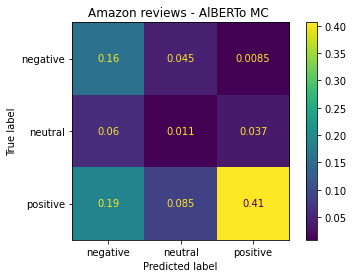

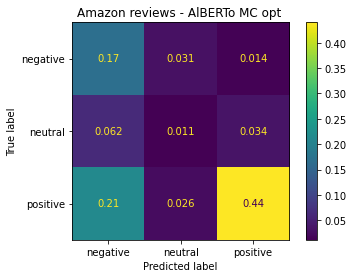

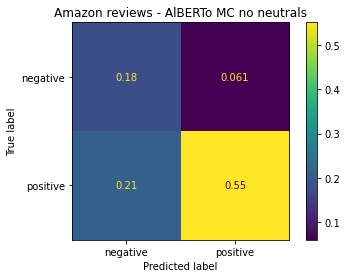

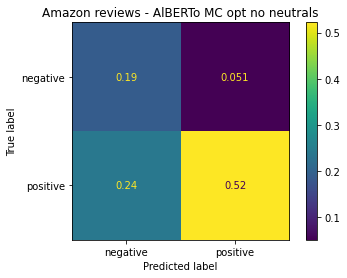

In [30]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC no neutrals\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=False, plot_confidence=False)
print("\n\n AlBERTo MC opt no neutrals\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_amazon_test, "Amazon reviews", keep_neutrals=False, plot_confidence=False)

### AlBERTo MC/opt fine tuned - Amazon reviews



 AlBERTo MC fine-tuned





              precision    recall  f1-score   support

    negative       0.77      0.73      0.75        75
     neutral       0.25      0.05      0.09        38
    positive       0.85      0.97      0.91       239

    accuracy                           0.82       352
   macro avg       0.62      0.59      0.58       352
weighted avg       0.77      0.82      0.79       352



 AlBERTo MC opt fine-tuned





              precision    recall  f1-score   support

    negative       0.71      0.53      0.61        75
     neutral       0.00      0.00      0.00        38
    positive       0.79      0.97      0.87       239

    accuracy                           0.77       352
   macro avg       0.50      0.50      0.49       352
weighted avg       0.69      0.77      0.72       352



 AlBERTo MC fine-tuned no neutrals





              precision    recall  f1-score   support

    negative       0.86      0.84      0.85        75
    positive       0.95      0.96      0.95       239

    accuracy                           0.93       314
   macro avg       0.91      0.90      0.90       314
weighted avg       0.93      0.93      0.93       314



 AlBERTo MC opt fine-tuned no neutrals





              precision    recall  f1-score   support

    negative       0.84      0.55      0.66        75
    positive       0.87      0.97      0.92       239

    accuracy                           0.87       314
   macro avg       0.85      0.76      0.79       314
weighted avg       0.86      0.87      0.86       314



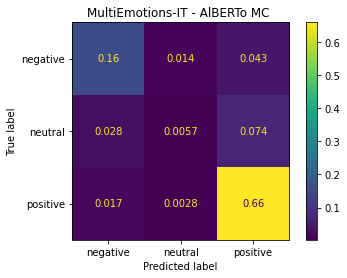

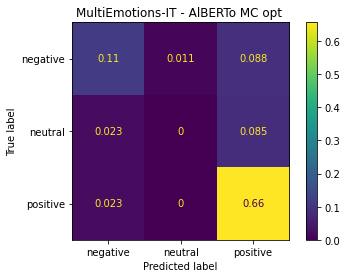

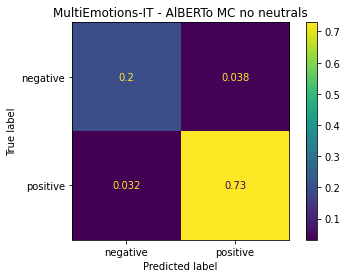

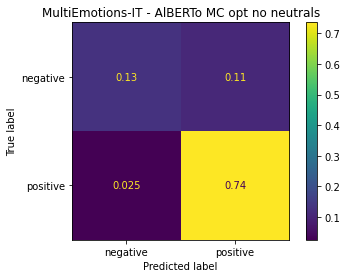

In [61]:
print("\n\n AlBERTo MC fine-tuned\n\n")
eval_alberto(MyNetMC, 
             "AlBERTo MC", 
             "models/alberto_multiclass.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="MC"
            )

print("\n\n AlBERTo MC opt fine-tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="opt"
            )

print("\n\n AlBERTo MC fine-tuned no neutrals\n\n")
eval_alberto(MyNetMC, 
             "AlBERTo MC", 
             "models/alberto_multiclass.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=False, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="MC"
            )

print("\n\n AlBERTo MC opt fine-tuned no neutrals\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_amazon_test, 
             "MultiEmotions-IT", 
             keep_neutrals=False, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             logging=False,
             model_type="opt"
            )

### AlBERTo opt - Amazon reviews with stop words removal

[nltk_data] Downloading package stopwords to /home/steve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




 AlBERTo MC opt no stop words





              precision    recall  f1-score   support

    negative       0.34      0.67      0.45        75
     neutral       0.11      0.16      0.13        38
    positive       0.87      0.55      0.67       239

    accuracy                           0.53       352
   macro avg       0.44      0.46      0.42       352
weighted avg       0.68      0.53      0.57       352



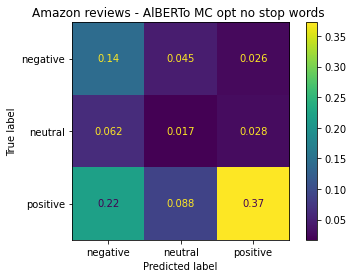

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

class AlBERTo_Preprocessing_Stop_words(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case
        self.stop_words = set(stopwords.words('italian'))

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = text_processor.pre_process_doc(text)
        filtered_text = [w for w in text if not w in self.stop_words]
        text = str(" ".join(filtered_text))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

b = AlBERTo_Preprocessing_Stop_words(do_lower_case=True)

dataset_amazon = pd.DataFrame({"text": amazon_test.text.apply(b.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)})
print("\n\n AlBERTo MC opt no stop words\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt no stop words", "models/alberto_multiclass_tuned.pt", dataset_amazon, "Amazon reviews", keep_neutrals=True, plot_confidence=False)

### Feel-it - Amazon reviews


              precision    recall  f1-score   support

    negative       0.63      0.88      0.74        75
    positive       0.96      0.84      0.90       239

    accuracy                           0.85       314
   macro avg       0.80      0.86      0.82       314
weighted avg       0.88      0.85      0.86       314




              precision    recall  f1-score   support

    negative       0.49      0.88      0.63        75
     neutral       0.00      0.00      0.00        38
    positive       0.92      0.84      0.88       239

    accuracy                           0.76       352
   macro avg       0.47      0.57      0.50       352
weighted avg       0.73      0.76      0.73       352



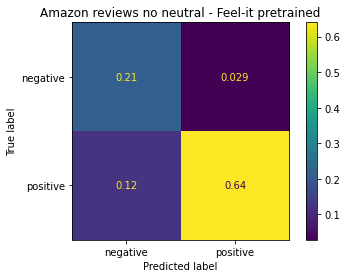

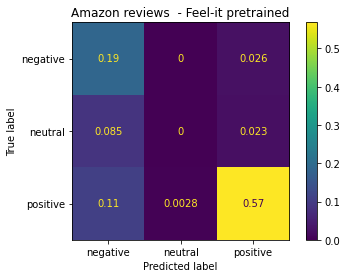

In [31]:
dataset = pd.DataFrame({"text": amazon_test.text.apply(a.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)})

eval_feelit_model(dataset, keep_neutrals=False, dataset_name="Amazon reviews", plot_confidence=False)
eval_feelit_model(dataset, keep_neutrals=True, dataset_name="Amazon reviews", plot_confidence=False)

# MultiEmotions-it

In [39]:
def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed/UNRELATED    -> 3
    """
    if row["POS"] == 0 and row["NEG"] == 0 and row["NEUT"] == 1:
        return 1
    elif row["NEG"] == 0 and row["POS"] == 1:
        return 2
    elif row["NEG"] == 1 and row["POS"] == 0:
        return 0
    else:
        return 3

##
# To split the dataset, one split, read the directly the 2 files
##
# me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it.tsv", sep='\t')
# me_train["labels"] = me_train[["POS", "NEG", "NEUT"]].apply(separate2united_labels, axis=1)

# X_train, X_test = train_test_split(me_train, test_size=0.15, random_state=42, stratify=me_train["labels"])
# X_train.to_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t', index=False)
# X_test.to_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t', index=False)

In [33]:
me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t')
me_test = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t')

me_train["text"] = me_train["comment"] 
me_test["text"] = me_test["comment"]

me_train.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
               'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
               'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)
me_test.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
               'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
               'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)

print("Train: ", len(me_train) , np.unique(me_train.labels, return_counts=True)[1]/len(me_train))
print("Test:", len(me_test) , np.unique(me_test.labels, return_counts=True)[1]/len(me_test))

print("\nAverage comment lenght Train: ", np.mean(me_train["text"].apply(len)))
print("\nAverage comment lenght Test: ", np.mean(me_test["text"].apply(len)))

me_test.head()

Train:  2754 [0.23710966 0.09114016 0.59150327 0.08024691]
Test: 486 [0.23662551 0.09053498 0.59259259 0.08024691]

Average comment lenght Train:  108.01234567901234

Average comment lenght Test:  106.6604938271605


,labels,text
0,2,Sei bella ❤️❤️
1,2,"Chi ama Riki metta like, lo amooo❤️❤️"
2,2,"Questo e un modo bellissimo per ""Celebrare"" se..."
3,1,Come si può avere la musica di sottofondo? Non...
4,0,In questi commenti mancano un po' di insulti c...


In [39]:
dataset_me_train = pd.DataFrame({"text": me_train.text.apply(a.preprocess), "idx": me_train.index, "labels": me_train["labels"].tolist()}) 
dataset_me_test = pd.DataFrame({"text": me_test.text.apply(a.preprocess), "idx": me_test.index, "labels": me_test["labels"].tolist()}) 

In [35]:
dataset_me_test.head()

,text,idx,labels
0,sei bella,0,2
1,chi ama riki metta like lo amoo,1,2
2,questo e un modo bellissimo per celebrare senz...,2,2
3,come si può avere la musica di sottofondo ? no...,3,1
4,in questi commenti mancano un po di insulti cr...,4,0


### AlBERTo MC/opt - MultiEmotions-IT



 AlBERTo MC





              precision    recall  f1-score   support

    negative       0.59      0.71      0.64       115
     neutral       0.39      0.64      0.48        44
    positive       0.96      0.78      0.86       288

    accuracy                           0.75       447
   macro avg       0.64      0.71      0.66       447
weighted avg       0.81      0.75      0.77       447



 AlBERTo MC opt





              precision    recall  f1-score   support

    negative       0.56      0.67      0.61       115
     neutral       0.35      0.57      0.43        44
    positive       0.93      0.77      0.84       288

    accuracy                           0.72       447
   macro avg       0.61      0.67      0.63       447
weighted avg       0.78      0.72      0.74       447



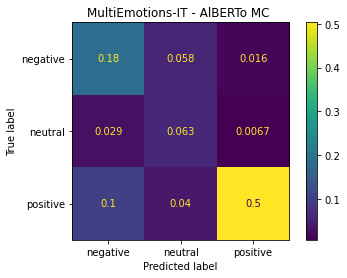

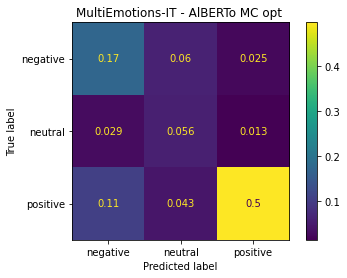

In [36]:
print("\n\n AlBERTo MC\n\n")
eval_alberto(MyNetMC, "AlBERTo MC", "models/alberto_multiclass.pt", dataset_me_test, "MultiEmotions-IT", keep_neutrals=True, plot_confidence=False)
print("\n\n AlBERTo MC opt\n\n")
eval_alberto(MyNetMCTuned, "AlBERTo MC opt", "models/alberto_multiclass_tuned.pt", dataset_me_test, "MultiEmotions-IT", keep_neutrals=True, plot_confidence=False)

### AlBERTo MC/opt fine-tuned - MultiEmotions-IT



 AlBERTo MC fine tuned





              precision    recall  f1-score   support

    negative       0.78      0.81      0.79       115
     neutral       0.63      0.55      0.59        44
    positive       0.92      0.93      0.93       288

    accuracy                           0.86       447
   macro avg       0.78      0.76      0.77       447
weighted avg       0.86      0.86      0.86       447



 AlBERTo MC opt fine tuned





              precision    recall  f1-score   support

    negative       0.73      0.80      0.76       115
     neutral       0.70      0.43      0.54        44
    positive       0.89      0.91      0.90       288

    accuracy                           0.84       447
   macro avg       0.78      0.72      0.73       447
weighted avg       0.83      0.84      0.83       447



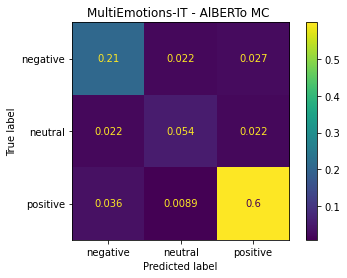

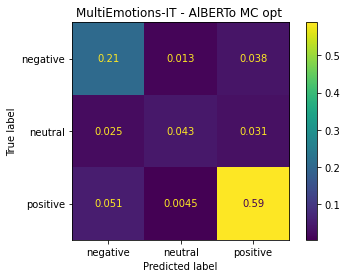

In [54]:
print("\n\n AlBERTo MC fine tuned\n\n")
eval_alberto(MyNetMC, 
             "AlBERTo MC", 
             "models/alberto_multiclass.pt", 
             dataset_me_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_me_train,
             logging=False,
             model_type="MC"
            )
print("\n\n AlBERTo MC opt fine tuned\n\n")
eval_alberto(MyNetMCTuned, 
             "AlBERTo MC opt", 
             "models/alberto_multiclass_tuned.pt", 
             dataset_me_test, 
             "MultiEmotions-IT", 
             keep_neutrals=True, 
             plot_confidence=False, 
             fine_tuning=True, 
             dataset_train=dataset_me_train,
             logging=False,
             model_type="opt"
            )

### Feel-IT - MultiEmotions-IT


              precision    recall  f1-score   support

    negative       0.50      0.90      0.64       115
     neutral       0.00      0.00      0.00        44
    positive       0.88      0.72      0.79       288

    accuracy                           0.70       447
   macro avg       0.46      0.54      0.48       447
weighted avg       0.70      0.70      0.68       447




              precision    recall  f1-score   support

    negative       0.57      0.90      0.70       115
    positive       0.95      0.72      0.82       288

    accuracy                           0.77       403
   macro avg       0.76      0.81      0.76       403
weighted avg       0.84      0.77      0.78       403



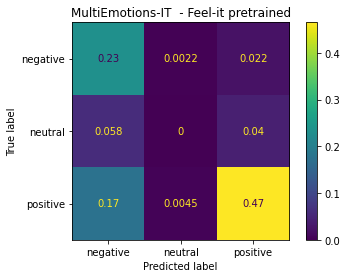

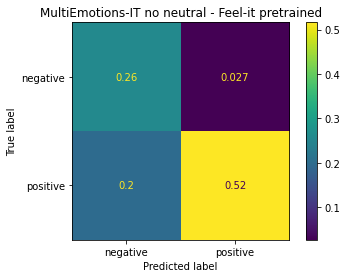

In [38]:
eval_feelit_model(dataset_me_test, keep_neutrals=True, dataset_name="MultiEmotions-IT", plot_confidence=False)
eval_feelit_model(dataset_me_test, keep_neutrals=False, dataset_name="MultiEmotions-IT", plot_confidence=False)